In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from scipy.io import arff
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from label_info import label_counter
import seaborn as sns
tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
Adam = tf.keras.optimizers.Adam


In [2]:
#fix the random seed for comparison
from numpy.random import seed
seed(11)
from tensorflow.random import set_seed
set_seed(22)
data,_ = arff.loadarff(r'./dataset/emotions.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1, random_state=1) #shuffle the data
rows,cols = df.shape
input_dim = cols-6
output_dim = 6

df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
518,0.109158,0.268949,0.076101,-60.018661,3.404251,0.610929,1.294005,-0.032829,0.707993,-0.214837,...,2.0,0.130155,0.474332,1.487590,b'1',b'0',b'0',b'0',b'0',b'1'
347,0.097436,0.251339,0.080042,-63.662213,3.899974,0.230644,1.252723,0.676819,0.076229,0.327339,...,2.0,0.278332,0.116057,0.829020,b'1',b'0',b'0',b'0',b'0',b'0'
395,0.063232,0.140621,0.082097,-66.596131,5.594724,0.350716,1.023655,0.439544,0.855564,0.414784,...,2.0,1.788567,0.032760,3.076057,b'0',b'0',b'0',b'0',b'1',b'0'
498,0.045979,0.285937,0.088668,-73.201192,4.868248,1.720746,1.374652,0.617047,0.522640,0.714393,...,3.0,0.213425,0.207252,0.929706,b'0',b'1',b'1',b'0',b'0',b'0'
460,0.027327,0.051877,0.083688,-76.692269,8.859399,0.366078,2.011369,1.104186,1.384590,0.231731,...,2.0,0.107568,0.301729,0.780669,b'0',b'0',b'1',b'1',b'1',b'0'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-6].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-6:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-6].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-6:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)

for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))

Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 178
Number of instances with 2 positive label(s): 315
Number of instances with 3 positive label(s): 100
Number of instances with 4 positive label(s): 0
Number of instances with 5 positive label(s): 0
Number of instances with 6 positive label(s): 0


In [4]:
train_size = np.shape(x_train)[0]
train_size

474

In [5]:
def create_model():
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(train_size, dtype='float32'))

    model = tf.keras.models.Sequential([
          Dense(
              110,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              80,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              60,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              30,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              40
              , activation='relu', dtype ='float32'),
          tfp.layers.DenseFlipout(
              output_dim, kernel_divergence_fn=kl_divergence_function,activation='sigmoid', dtype ='float32'),
  ])
    return model
model = create_model()

C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


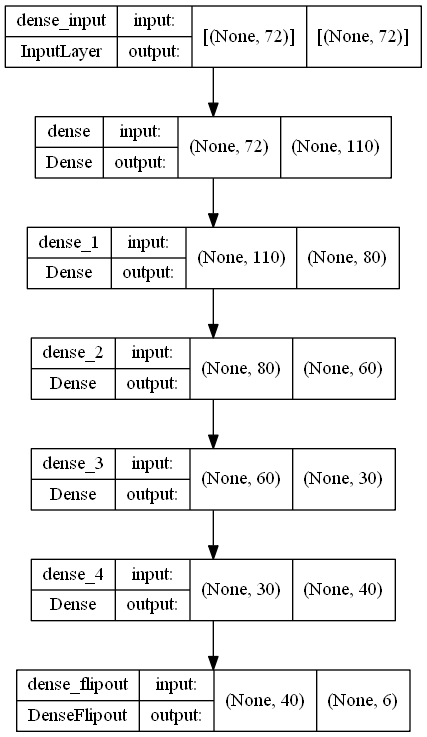

In [6]:
plot_model(model, to_file='./Model_Last_Layer_BNN_Emotion.png', show_shapes=True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 110)               8030      
                                                                 
 dense_1 (Dense)             (None, 80)                8880      
                                                                 
 dense_2 (Dense)             (None, 60)                4860      
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 40)                1240      
                                                                 
 dense_flipout (DenseFlipout  (None, 6)                486       
 )                                                               
                                                        

In [8]:
model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.25,shuffle=True)

Epoch 1/300
3/3 [==============================] - 2s 197ms/step - loss: 3.0540 - binary_accuracy: 0.5056 - hamming_loss: 0.4929 - precision_micro: 0.3338 - recall_micro: 0.5680 - f1_micro: 0.4202 - val_loss: 2.4825 - val_binary_accuracy: 0.5196 - val_hamming_loss: 0.4804 - val_precision_micro: 0.2913 - val_recall_micro: 0.4206 - val_f1_micro: 0.3442
Epoch 2/300
3/3 [==============================] - 0s 15ms/step - loss: 2.2895 - binary_accuracy: 0.5634 - hamming_loss: 0.4353 - precision_micro: 0.3411 - recall_micro: 0.4282 - f1_micro: 0.3775 - val_loss: 2.1829 - val_binary_accuracy: 0.5980 - val_hamming_loss: 0.4020 - val_precision_micro: 0.3184 - val_recall_micro: 0.2991 - val_f1_micro: 0.3084
Epoch 3/300
3/3 [==============================] - 0s 16ms/step - loss: 2.1671 - binary_accuracy: 0.5995 - hamming_loss: 0.4016 - precision_micro: 0.3283 - recall_micro: 0.2734 - f1_micro: 0.2973 - val_loss: 2.1852 - val_binary_accuracy: 0.5882 - val_hamming_loss: 0.4118 - val_precision_micro: 

3/3 [==============================] - 0s 14ms/step - loss: 1.8963 - binary_accuracy: 0.6761 - hamming_loss: 0.3230 - precision_micro: 0.4319 - recall_micro: 0.1055 - f1_micro: 0.1694 - val_loss: 1.8922 - val_binary_accuracy: 0.6947 - val_hamming_loss: 0.3053 - val_precision_micro: 0.4655 - val_recall_micro: 0.1262 - val_f1_micro: 0.1985
Epoch 25/300
3/3 [==============================] - 0s 16ms/step - loss: 1.8892 - binary_accuracy: 0.6789 - hamming_loss: 0.3201 - precision_micro: 0.4415 - recall_micro: 0.1161 - f1_micro: 0.1819 - val_loss: 1.8756 - val_binary_accuracy: 0.6947 - val_hamming_loss: 0.3053 - val_precision_micro: 0.4677 - val_recall_micro: 0.1355 - val_f1_micro: 0.2101
Epoch 26/300
3/3 [==============================] - 0s 18ms/step - loss: 1.8899 - binary_accuracy: 0.6840 - hamming_loss: 0.3164 - precision_micro: 0.4870 - recall_micro: 0.1562 - f1_micro: 0.2357 - val_loss: 1.8836 - val_binary_accuracy: 0.6891 - val_hamming_loss: 0.3109 - val_precision_micro: 0.4375 - va

3/3 [==============================] - 0s 14ms/step - loss: 1.8584 - binary_accuracy: 0.6958 - hamming_loss: 0.3026 - precision_micro: 0.6026 - recall_micro: 0.1172 - f1_micro: 0.1954 - val_loss: 1.8548 - val_binary_accuracy: 0.7045 - val_hamming_loss: 0.2955 - val_precision_micro: 0.5283 - val_recall_micro: 0.1308 - val_f1_micro: 0.2097
Epoch 48/300
3/3 [==============================] - 0s 15ms/step - loss: 1.8553 - binary_accuracy: 0.7009 - hamming_loss: 0.2985 - precision_micro: 0.6104 - recall_micro: 0.1365 - f1_micro: 0.2228 - val_loss: 1.8472 - val_binary_accuracy: 0.6849 - val_hamming_loss: 0.3151 - val_precision_micro: 0.3878 - val_recall_micro: 0.0888 - val_f1_micro: 0.1445
Epoch 49/300
3/3 [==============================] - 0s 14ms/step - loss: 1.8528 - binary_accuracy: 0.7028 - hamming_loss: 0.2960 - precision_micro: 0.6116 - recall_micro: 0.1435 - f1_micro: 0.2322 - val_loss: 1.8516 - val_binary_accuracy: 0.6975 - val_hamming_loss: 0.3025 - val_precision_micro: 0.4792 - va

3/3 [==============================] - 0s 15ms/step - loss: 1.7840 - binary_accuracy: 0.7300 - hamming_loss: 0.2707 - precision_micro: 0.6703 - recall_micro: 0.2755 - f1_micro: 0.3896 - val_loss: 1.7751 - val_binary_accuracy: 0.7297 - val_hamming_loss: 0.2703 - val_precision_micro: 0.6154 - val_recall_micro: 0.2617 - val_f1_micro: 0.3672
Epoch 71/300
3/3 [==============================] - 0s 14ms/step - loss: 1.7862 - binary_accuracy: 0.7192 - hamming_loss: 0.2819 - precision_micro: 0.6120 - recall_micro: 0.2739 - f1_micro: 0.3782 - val_loss: 1.7805 - val_binary_accuracy: 0.7255 - val_hamming_loss: 0.2745 - val_precision_micro: 0.5957 - val_recall_micro: 0.2617 - val_f1_micro: 0.3636
Epoch 72/300
3/3 [==============================] - 0s 14ms/step - loss: 1.7812 - binary_accuracy: 0.7286 - hamming_loss: 0.2715 - precision_micro: 0.6468 - recall_micro: 0.2979 - f1_micro: 0.4075 - val_loss: 1.7868 - val_binary_accuracy: 0.7311 - val_hamming_loss: 0.2689 - val_precision_micro: 0.5982 - va

3/3 [==============================] - 0s 15ms/step - loss: 1.7330 - binary_accuracy: 0.7408 - hamming_loss: 0.2583 - precision_micro: 0.6218 - recall_micro: 0.4496 - f1_micro: 0.5217 - val_loss: 1.7110 - val_binary_accuracy: 0.7535 - val_hamming_loss: 0.2465 - val_precision_micro: 0.6187 - val_recall_micro: 0.4626 - val_f1_micro: 0.5294
Epoch 94/300
3/3 [==============================] - 0s 14ms/step - loss: 1.7230 - binary_accuracy: 0.7563 - hamming_loss: 0.2432 - precision_micro: 0.6476 - recall_micro: 0.4842 - f1_micro: 0.5539 - val_loss: 1.7341 - val_binary_accuracy: 0.7451 - val_hamming_loss: 0.2549 - val_precision_micro: 0.6081 - val_recall_micro: 0.4206 - val_f1_micro: 0.4972
Epoch 95/300
3/3 [==============================] - 0s 18ms/step - loss: 1.7252 - binary_accuracy: 0.7502 - hamming_loss: 0.2497 - precision_micro: 0.6422 - recall_micro: 0.4533 - f1_micro: 0.5294 - val_loss: 1.7104 - val_binary_accuracy: 0.7549 - val_hamming_loss: 0.2451 - val_precision_micro: 0.6345 - va

3/3 [==============================] - 0s 14ms/step - loss: 1.6845 - binary_accuracy: 0.7681 - hamming_loss: 0.2299 - precision_micro: 0.6877 - recall_micro: 0.4860 - f1_micro: 0.5671 - val_loss: 1.6874 - val_binary_accuracy: 0.7633 - val_hamming_loss: 0.2367 - val_precision_micro: 0.6433 - val_recall_micro: 0.4720 - val_f1_micro: 0.5445
Epoch 117/300
3/3 [==============================] - 0s 13ms/step - loss: 1.6825 - binary_accuracy: 0.7714 - hamming_loss: 0.2294 - precision_micro: 0.6824 - recall_micro: 0.5064 - f1_micro: 0.5807 - val_loss: 1.6986 - val_binary_accuracy: 0.7535 - val_hamming_loss: 0.2465 - val_precision_micro: 0.6234 - val_recall_micro: 0.4486 - val_f1_micro: 0.5217
Epoch 118/300
3/3 [==============================] - 0s 14ms/step - loss: 1.6867 - binary_accuracy: 0.7681 - hamming_loss: 0.2325 - precision_micro: 0.6763 - recall_micro: 0.4993 - f1_micro: 0.5740 - val_loss: 1.6907 - val_binary_accuracy: 0.7773 - val_hamming_loss: 0.2227 - val_precision_micro: 0.6797 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.6534 - binary_accuracy: 0.7695 - hamming_loss: 0.2299 - precision_micro: 0.6699 - recall_micro: 0.5261 - f1_micro: 0.5891 - val_loss: 1.6630 - val_binary_accuracy: 0.7577 - val_hamming_loss: 0.2423 - val_precision_micro: 0.6096 - val_recall_micro: 0.5327 - val_f1_micro: 0.5686
Epoch 140/300
3/3 [==============================] - 0s 16ms/step - loss: 1.6535 - binary_accuracy: 0.7770 - hamming_loss: 0.2226 - precision_micro: 0.6949 - recall_micro: 0.5194 - f1_micro: 0.5944 - val_loss: 1.6739 - val_binary_accuracy: 0.7507 - val_hamming_loss: 0.2493 - val_precision_micro: 0.6023 - val_recall_micro: 0.4953 - val_f1_micro: 0.5436
Epoch 141/300
3/3 [==============================] - 0s 14ms/step - loss: 1.6515 - binary_accuracy: 0.7742 - hamming_loss: 0.2266 - precision_micro: 0.6910 - recall_micro: 0.5069 - f1_micro: 0.5847 - val_loss: 1.6676 - val_binary_accuracy: 0.7717 - val_hamming_loss: 0.2283 - val_precision_micro: 0.6604 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.6329 - binary_accuracy: 0.7770 - hamming_loss: 0.2246 - precision_micro: 0.6859 - recall_micro: 0.5161 - f1_micro: 0.5885 - val_loss: 1.6445 - val_binary_accuracy: 0.7703 - val_hamming_loss: 0.2297 - val_precision_micro: 0.6374 - val_recall_micro: 0.5421 - val_f1_micro: 0.5859
Epoch 163/300
3/3 [==============================] - 0s 14ms/step - loss: 1.6331 - binary_accuracy: 0.7732 - hamming_loss: 0.2290 - precision_micro: 0.6856 - recall_micro: 0.4978 - f1_micro: 0.5762 - val_loss: 1.6485 - val_binary_accuracy: 0.7717 - val_hamming_loss: 0.2283 - val_precision_micro: 0.6491 - val_recall_micro: 0.5187 - val_f1_micro: 0.5766
Epoch 164/300
3/3 [==============================] - 0s 14ms/step - loss: 1.6267 - binary_accuracy: 0.7812 - hamming_loss: 0.2181 - precision_micro: 0.6897 - recall_micro: 0.5476 - f1_micro: 0.6099 - val_loss: 1.6361 - val_binary_accuracy: 0.7773 - val_hamming_loss: 0.2227 - val_precision_micro: 0.6519 - 

3/3 [==============================] - 0s 20ms/step - loss: 1.5963 - binary_accuracy: 0.7817 - hamming_loss: 0.2191 - precision_micro: 0.6932 - recall_micro: 0.5368 - f1_micro: 0.6043 - val_loss: 1.6283 - val_binary_accuracy: 0.7787 - val_hamming_loss: 0.2213 - val_precision_micro: 0.6609 - val_recall_micro: 0.5374 - val_f1_micro: 0.5928
Epoch 186/300
3/3 [==============================] - 0s 17ms/step - loss: 1.5962 - binary_accuracy: 0.7836 - hamming_loss: 0.2155 - precision_micro: 0.7028 - recall_micro: 0.5430 - f1_micro: 0.6126 - val_loss: 1.6326 - val_binary_accuracy: 0.7829 - val_hamming_loss: 0.2171 - val_precision_micro: 0.6453 - val_recall_micro: 0.6121 - val_f1_micro: 0.6283
Epoch 187/300
3/3 [==============================] - 0s 15ms/step - loss: 1.5956 - binary_accuracy: 0.7817 - hamming_loss: 0.2180 - precision_micro: 0.6812 - recall_micro: 0.5676 - f1_micro: 0.6181 - val_loss: 1.6369 - val_binary_accuracy: 0.7675 - val_hamming_loss: 0.2325 - val_precision_micro: 0.6364 - 

3/3 [==============================] - 0s 15ms/step - loss: 1.5720 - binary_accuracy: 0.7915 - hamming_loss: 0.2094 - precision_micro: 0.7072 - recall_micro: 0.5697 - f1_micro: 0.6306 - val_loss: 1.6026 - val_binary_accuracy: 0.7871 - val_hamming_loss: 0.2129 - val_precision_micro: 0.6703 - val_recall_micro: 0.5701 - val_f1_micro: 0.6162
Epoch 209/300
3/3 [==============================] - 0s 15ms/step - loss: 1.5640 - binary_accuracy: 0.7972 - hamming_loss: 0.2024 - precision_micro: 0.7240 - recall_micro: 0.5737 - f1_micro: 0.6388 - val_loss: 1.6020 - val_binary_accuracy: 0.7745 - val_hamming_loss: 0.2255 - val_precision_micro: 0.6464 - val_recall_micro: 0.5467 - val_f1_micro: 0.5924
Epoch 210/300
3/3 [==============================] - 0s 14ms/step - loss: 1.5744 - binary_accuracy: 0.7977 - hamming_loss: 0.2019 - precision_micro: 0.7260 - recall_micro: 0.5751 - f1_micro: 0.6414 - val_loss: 1.6096 - val_binary_accuracy: 0.7787 - val_hamming_loss: 0.2213 - val_precision_micro: 0.6538 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.5460 - binary_accuracy: 0.7939 - hamming_loss: 0.2074 - precision_micro: 0.7058 - recall_micro: 0.5733 - f1_micro: 0.6320 - val_loss: 1.5895 - val_binary_accuracy: 0.7871 - val_hamming_loss: 0.2129 - val_precision_micro: 0.6615 - val_recall_micro: 0.5935 - val_f1_micro: 0.6256
Epoch 232/300
3/3 [==============================] - 0s 14ms/step - loss: 1.5446 - binary_accuracy: 0.8028 - hamming_loss: 0.1965 - precision_micro: 0.7246 - recall_micro: 0.6030 - f1_micro: 0.6580 - val_loss: 1.5950 - val_binary_accuracy: 0.7773 - val_hamming_loss: 0.2227 - val_precision_micro: 0.6425 - val_recall_micro: 0.5794 - val_f1_micro: 0.6093
Epoch 233/300
3/3 [==============================] - 0s 14ms/step - loss: 1.5472 - binary_accuracy: 0.8094 - hamming_loss: 0.1905 - precision_micro: 0.7403 - recall_micro: 0.6062 - f1_micro: 0.6658 - val_loss: 1.5931 - val_binary_accuracy: 0.7955 - val_hamming_loss: 0.2045 - val_precision_micro: 0.6809 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.5329 - binary_accuracy: 0.7953 - hamming_loss: 0.2056 - precision_micro: 0.7135 - recall_micro: 0.5768 - f1_micro: 0.6371 - val_loss: 1.5684 - val_binary_accuracy: 0.7815 - val_hamming_loss: 0.2185 - val_precision_micro: 0.6667 - val_recall_micro: 0.5421 - val_f1_micro: 0.5979
Epoch 255/300
3/3 [==============================] - 0s 14ms/step - loss: 1.5239 - binary_accuracy: 0.8033 - hamming_loss: 0.1970 - precision_micro: 0.7416 - recall_micro: 0.5765 - f1_micro: 0.6479 - val_loss: 1.5802 - val_binary_accuracy: 0.7927 - val_hamming_loss: 0.2073 - val_precision_micro: 0.6755 - val_recall_micro: 0.5935 - val_f1_micro: 0.6318
Epoch 256/300
3/3 [==============================] - 0s 14ms/step - loss: 1.5329 - binary_accuracy: 0.8052 - hamming_loss: 0.1964 - precision_micro: 0.7289 - recall_micro: 0.5959 - f1_micro: 0.6554 - val_loss: 1.5810 - val_binary_accuracy: 0.7717 - val_hamming_loss: 0.2283 - val_precision_micro: 0.6244 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.4967 - binary_accuracy: 0.8131 - hamming_loss: 0.1865 - precision_micro: 0.7433 - recall_micro: 0.6188 - f1_micro: 0.6751 - val_loss: 1.5655 - val_binary_accuracy: 0.7815 - val_hamming_loss: 0.2185 - val_precision_micro: 0.6450 - val_recall_micro: 0.6028 - val_f1_micro: 0.6232
Epoch 278/300
3/3 [==============================] - 0s 14ms/step - loss: 1.4925 - binary_accuracy: 0.8131 - hamming_loss: 0.1879 - precision_micro: 0.7352 - recall_micro: 0.6258 - f1_micro: 0.6761 - val_loss: 1.5601 - val_binary_accuracy: 0.7829 - val_hamming_loss: 0.2171 - val_precision_micro: 0.6453 - val_recall_micro: 0.6121 - val_f1_micro: 0.6283
Epoch 279/300
3/3 [==============================] - 0s 13ms/step - loss: 1.4994 - binary_accuracy: 0.8014 - hamming_loss: 0.1989 - precision_micro: 0.7148 - recall_micro: 0.6089 - f1_micro: 0.6572 - val_loss: 1.5511 - val_binary_accuracy: 0.7913 - val_hamming_loss: 0.2087 - val_precision_micro: 0.6702 - 

3/3 [==============================] - 0s 14ms/step - loss: 1.4695 - binary_accuracy: 0.8282 - hamming_loss: 0.1702 - precision_micro: 0.7683 - recall_micro: 0.6540 - f1_micro: 0.7057 - val_loss: 1.5381 - val_binary_accuracy: 0.7787 - val_hamming_loss: 0.2213 - val_precision_micro: 0.6429 - val_recall_micro: 0.5888 - val_f1_micro: 0.6146


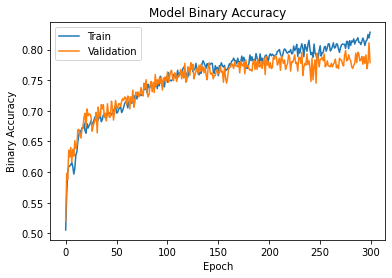

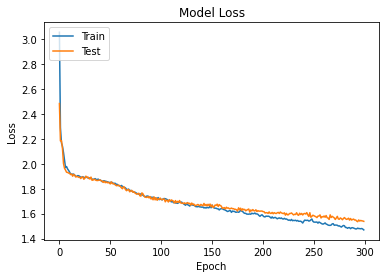

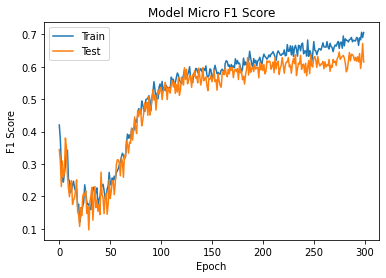

In [10]:
#Visualisation
#acc
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#f1
plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model Micro F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

4/4 [==============================] - 0s 2ms/step - loss: 1.6163 - binary_accuracy: 0.7647 - hamming_loss: 0.2356 - precision_micro: 0.6541 - recall_micro: 0.5394 - f1_micro: 0.5892
Test:
Loss: 1.616347312927246
Binary-Accuracy(the same as Micro-Accuracy): 0.7647058963775635 
Hamming_Loss: 0.23556385934352875 
Micro-Precision: 0.6541266441345215 
Micro-Recall: 0.5394321084022522 
Micro-F1 Score: 0.5892386436462402


In [12]:
y_pred = model.predict(x_test)

In [13]:
instance_1 = np.reshape(x_test[45],(1,72))
instance_2 = np.reshape(x_test[50],(1,72))

In [14]:
num_ensemble = 500
y_pred_all_idx1 = []
y_pred_all_idx2 = []
y_pred_all = []
for e in range(num_ensemble):
    
    y_pred_idx1 = model.predict(instance_1)
    y_pred_all_idx1.append(y_pred_idx1)
    y_pred_idx2 = model.predict(instance_2)
    y_pred_all_idx2.append(y_pred_idx2)
    y_pred = model.predict(x_test)
    y_pred_all.append(y_pred)

In [15]:
y_pred_m_1 = np.mean(y_pred_all_idx1, axis=0)
y_pred_s_1 = np.std(y_pred_all_idx1, axis=0)
y_pred_m_2 = np.mean(y_pred_all_idx2, axis=0)
y_pred_s_2 = np.std(y_pred_all_idx2, axis=0)
y_pred_m = np.mean(y_pred_all,axis=0)
y_pred_s = np.std(y_pred_all,axis=0)
labels=np.linspace(1,6,6)


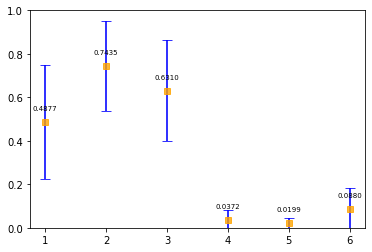

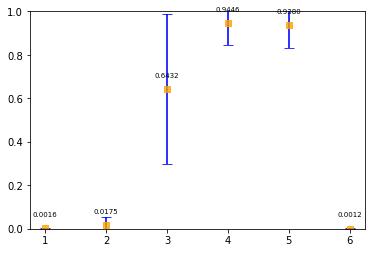

In [16]:
plt.errorbar(labels,y_pred_m_1[0],yerr=1.96*y_pred_s_1[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_1[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_1_Emotion.jpg" ,bbox_inches="tight")    
plt.show()
plt.errorbar(labels,y_pred_m_2[0],yerr=1.96*y_pred_s_2[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_2[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_2_Emotion.jpg" ,bbox_inches="tight")  
plt.show()

In [17]:
np.sum(y_test,axis=1)

array([3, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 3, 3, 2, 1,
       2, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 3, 1, 2, 1, 2, 3, 2, 2, 1, 2, 2,
       2, 3, 3, 1, 2, 1, 2, 1, 2, 3, 2, 2, 1, 1, 2, 3, 3, 3, 2, 2, 2, 1,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2,
       3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 2, 1,
       1, 2, 2, 2, 1, 2, 1, 3, 2])

In [18]:
print(y_test[50])
y_pred[50]


[0 0 0 1 1 0]


array([5.3346157e-04, 1.5969962e-02, 5.9379166e-01, 8.9896262e-01,
       9.6946108e-01, 1.4173985e-03], dtype=float32)

In [19]:
y_pred_m #ensemble's mean predictive value used for ECE and Reliability Diagramm

array([[7.91590437e-02, 1.69320256e-01, 9.87587154e-01, 6.08529925e-01,
        5.30053079e-02, 5.26801450e-03],
       [6.51850879e-01, 6.38657570e-01, 2.53520221e-01, 1.81397125e-02,
        6.23536631e-02, 2.85234511e-01],
       [1.35224521e-01, 2.37384841e-01, 4.33488965e-01, 1.61314338e-01,
        3.68012697e-01, 2.60533959e-01],
       [7.09831953e-01, 4.04206634e-01, 5.07011525e-02, 1.78446388e-03,
        3.45048867e-02, 6.71856821e-01],
       [4.36030068e-02, 1.53595701e-01, 6.14281058e-01, 6.77371204e-01,
        6.97866023e-01, 3.14194970e-02],
       [3.99520367e-01, 6.59495234e-01, 5.63541889e-01, 7.78873861e-02,
        1.03554852e-01, 1.23153150e-01],
       [2.80172050e-01, 3.76269162e-01, 4.13375407e-01, 4.34859581e-02,
        1.83291554e-01, 2.31494918e-01],
       [1.36292547e-01, 4.06501412e-01, 8.19962680e-01, 1.49336979e-01,
        1.77885845e-01, 8.02025646e-02],
       [4.87893308e-03, 2.42678430e-02, 6.12712324e-01, 9.51383233e-01,
        9.58038867e-01, 

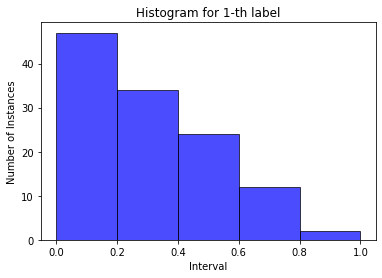

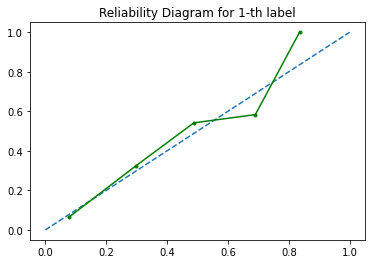

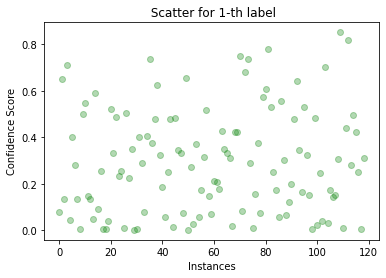

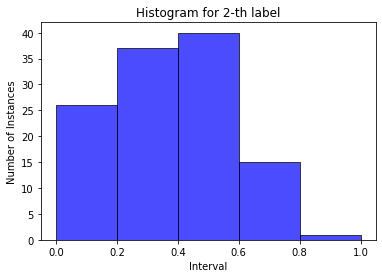

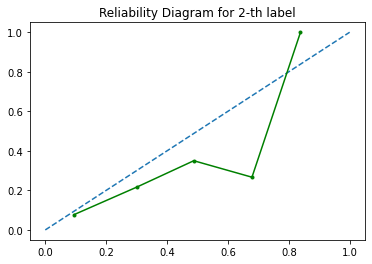

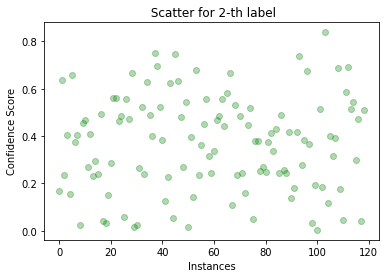

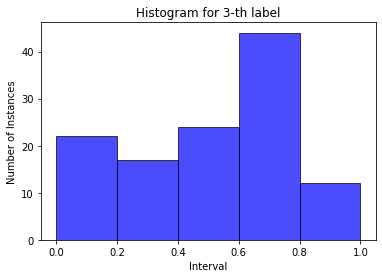

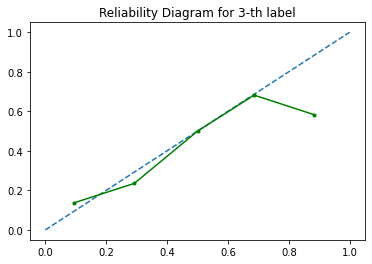

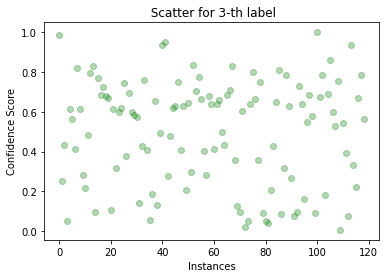

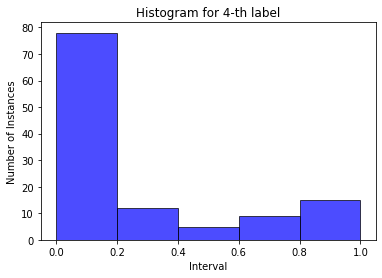

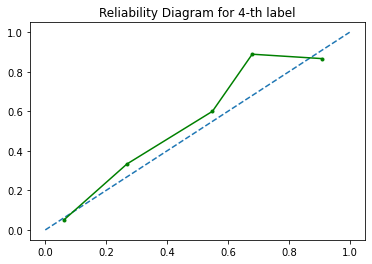

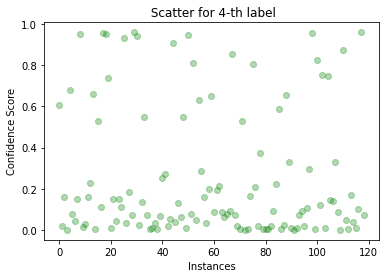

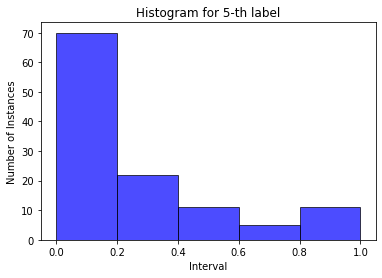

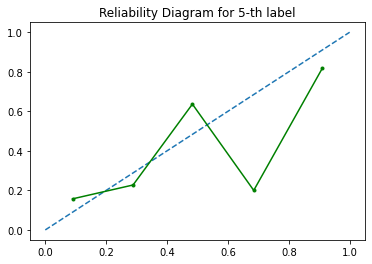

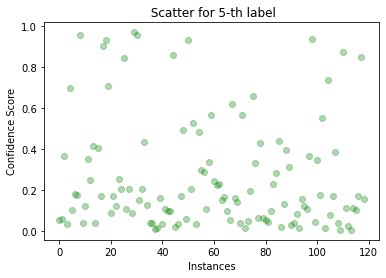

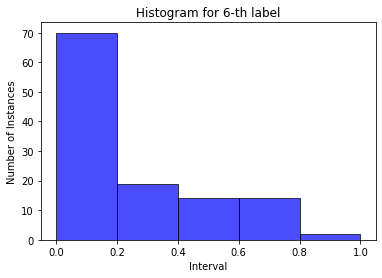

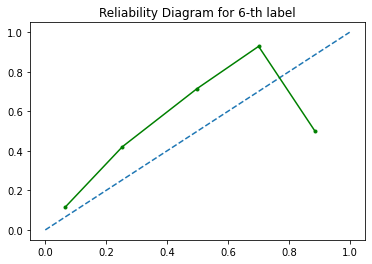

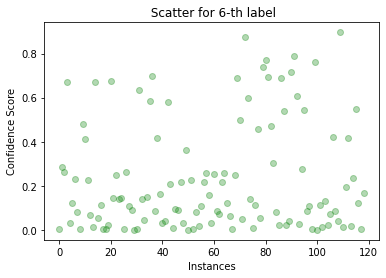

Expected Calibration Error for each label = [0.03712816021753428, 0.12943714313960378, 0.04800671919350742, 0.03660757124514225, 0.09405565715371433, 0.11456500702216475]
Average Expected Calibration Error for all labels = 0.07663337632861114


In [20]:
from sklearn.calibration import calibration_curve
from BM import bm_counter
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
bins =5
for i in range(np.shape(y_test)[1]):
    #histogram
    plt.hist(y_pred_m[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./Last_Layer_BNN_Emotion_Hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred_m[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred_m[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred_m)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated',color = "green")
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.savefig("./Last_Layer_BNN_Emotion_RD_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_m)[0]),y_pred_m[:,i],color = "green",label = ' uncalibrated',alpha= 0.3)
    plt.title(' Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./Emotion_Scatter_Last_Layer_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
print('Expected Calibration Error for each label = %s' %ECE)
avg_ECE = np.mean(ECE)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)

In [21]:
predictions = (y_pred_m > 0.5).astype("int32")
recall_macro(y_test,predictions)

(array([0.41666667, 0.48275862, 0.78571429, 0.75      , 0.39393939,
        0.45      ]),
 0.5465131611683336)

In [22]:
precision_macro(y_test,predictions)

(array([0.65217391, 0.4375    , 0.65671642, 0.82758621, 0.65      ,
        0.81818182]),
 0.6736930593387159)

In [23]:
f1_macro(y_test,predictions)

(array([0.50847458, 0.45901639, 0.71544715, 0.78688525, 0.49056604,
        0.58064516]),
 0.5901724281855275)

In [24]:
accuracy_each_label(y_test,predictions)

array([0.75630252, 0.72268908, 0.70588235, 0.8907563 , 0.77310924,
       0.78151261])

In [25]:
np.mean(accuracy_each_label(y_test,predictions))

0.7717086834733894

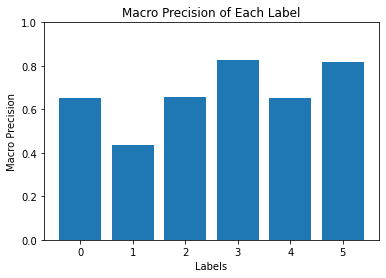

In [26]:
plt.bar(range(6),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./BNN_scene_macro_precision.jpg" )

In [27]:
ECE_BL = [0.18760606587419543, 0.12314847053899988, 0.19154308655220306, 0.06232874566486146, 0.12375525089957606, 0.12167767746754977]

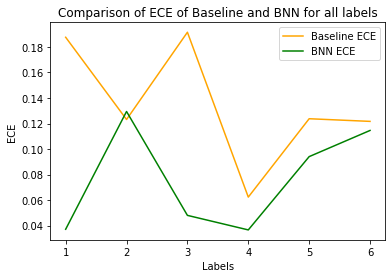

In [28]:
#calibrated model for test data evaluation Macro
plt.plot([1,2,3,4,5,6],ECE_BL, label='Baseline ECE',color = "orange")
plt.plot([1,2,3,4,5,6],ECE,color = "green",label = 'BNN ECE')
plt.title('Comparison of ECE of Baseline and BNN for all labels')
plt.ylabel('ECE')
plt.xlabel('Labels')
plt.legend()
plt.savefig("./emotione_ece_comparison_BNN.jpg" )
plt.show()
